<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Sommaire
        </h1>
    </div>
</div>

- **[Preparation du dataset](#pre)**

- **[Verification des annotations](#ve)**

- **[Yolo v5 entrainement](#en)**

- **[Resultat](#re)**

- **[Test du modele](#te)**





In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13049, done.
remote: Total 13049 (delta 0), reused 0 (delta 0), pack-reused 13049
Receiving objects: 100% (13049/13049), 11.92 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (9070/9070), done.


In [2]:
pip install -r yolov5/requirements.txt

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [4]:
!mkdir Road_Sign_Dataset

In [3]:
!pwd

/media/ismail/Elements/formation/projet7/livrable


In [5]:
cd ./Road_Sign_Dataset

[Errno 2] No such file or directory: './Road_Sign_Dataset'
/media/ismail/Elements/formation/projet7/livrable


In [6]:
!pwd

/content/Road_Sign_Dataset


In [6]:
cd /media/ismail/Elements/formation/projet7/feux/RoadSignDetectionDataset

/media/ismail/Elements/formation/projet7/feux/RoadSignDetectionDataset


In [8]:
 !rm -rf /content/annotations/

In [9]:
!wget -O RoadSignDetectionDataset.zip https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2

--2022-04-29 11:46:14--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 18.66.3.200
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|18.66.3.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229344361 (219M) [application/zip]
Saving to: ‘RoadSignDetectionDataset.zip’

RoadSignDetectionDa 100%[===================>] 218.72M  44.7MB/s    in 5.6s    

2022-04-29 11:46:21 (38.8 MB/s) - ‘RoadSignDetectionDataset.zip’ saved [229344361/229344361]



In [ ]:
!unzip RoadSignDetectionDataset.zip

In [11]:
rm -rf __MACOSX RoadSignDetectionDataset.zip

<a name='pre'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preparation du datatset
        </h1>
    </div>
</div>

In [7]:
cat annotations/road4.xml


<annotation>
    <folder>images</folder>
    <filename>road4.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>20</xmin>
            <ymin>109</ymin>
            <xmax>81</xmax>
            <ymax>237</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>162</ymin>
            <xmax>163</xmax>
            <ymax>272</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

In [8]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [9]:
print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [10]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [11]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|████████████████████████████████████████| 877/877 [00:04<00:00, 195.90it/s]


<a name='ve'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Verification des annotations
        </h1>
    </div>
</div>

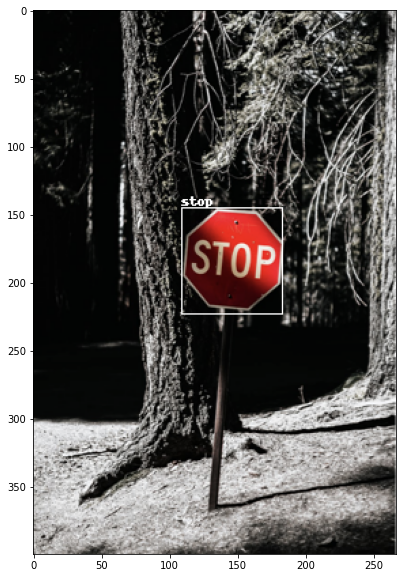

In [13]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

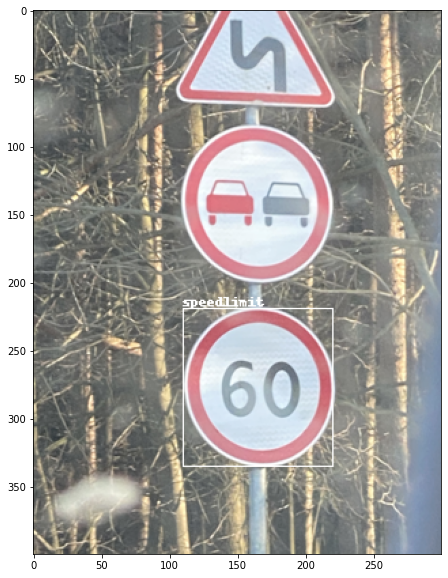

In [16]:
random.seed(20)
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

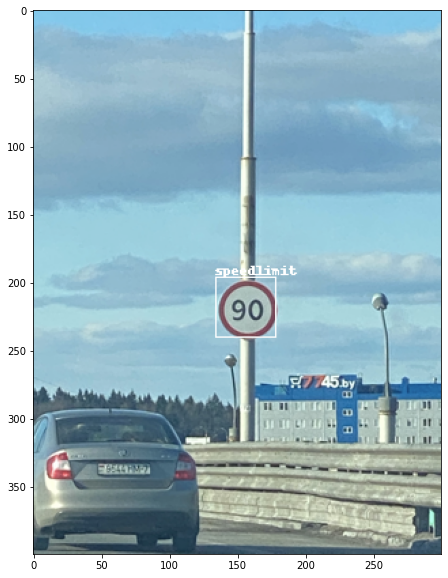

In [20]:
random.seed(100)
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
#Load the image
image = Image.open(image_file)
fig = plt.figure(figsize=(12,10))
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [18]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [19]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [20]:
!pwd

/content/Road_Sign_Dataset


In [21]:
!rm -rf -d labels/*.xml

In [22]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [23]:
!mv annotations labels

In [24]:
cd /content/yolov5/ 

/content/yolov5


In [25]:
!pwd

/content/yolov5


In [26]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


<a name='pa'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Yolo v5 entrainement
        </h1>
    </div>
</div>


In [27]:
!cp -avr /content/ShardDrives/MyDrive/roadsign/road_sign_data.yaml /content/yolov5/data/road_sign_data.yaml

'/content/ShardDrives/MyDrive/roadsign/road_sign_data.yaml' -> '/content/yolov5/data/road_sign_data.yaml'


In [30]:
!python train.py --img 640 --batch 16 --epochs 50 --data road_sign_data.yaml --cfg yolov5l.yaml --hyp hyp.scratch-med.yaml --weights yolov5l.pt --name yolo_road_det --device 0 --cache

train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=road_sign_data.yaml, hyp=hyp.scratch-med.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hs

<a name='re'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Resultat
        </h1>
    </div>
</div>

In [79]:
!python val.py --weights /content/yolov5/runs/train/yolo_road_det/weights/best.pt --data road_sign_data.yaml --task test --name yolo_road_test --augment --verbose --device 0

val: data=/content/yolov5/data/road_sign_data.yaml, weights=['/content/yolov5/runs/train/yolo_road_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=0, workers=8, single_cls=False, augment=True, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_road_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46124433 parameters, 0 gradients, 107.8 GFLOPs
test: Scanning '/content/yolov5/../Road_Sign_Dataset/labels/test.cache' images and labels... 88 found, 0 missing, 0 empty, 0 corrupt: 100% 88/88 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:03<00:00,  1.08s/it]
                 all         88        126       0.98      0.914      0.942      0.796
        trafficlight         88         20 

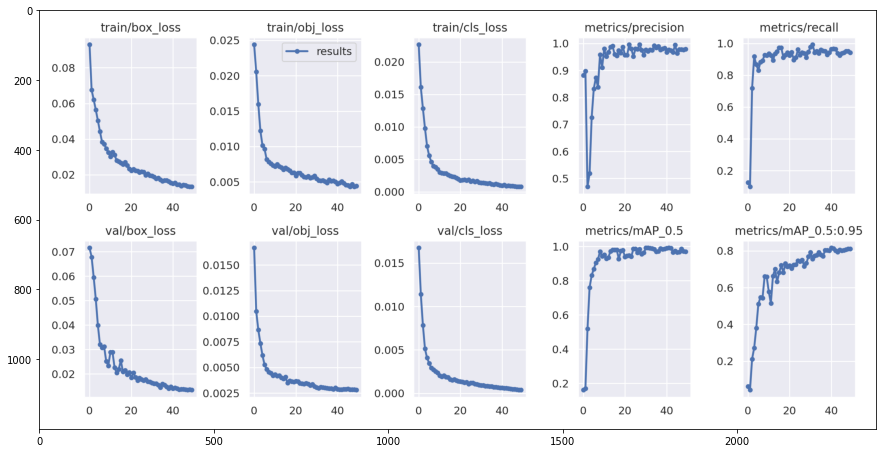

In [90]:
plt.figure(figsize=(15,15)) 
plt.imshow(np.array(Image.open("/content/yolov5/runs/train/yolo_road_det/results.png")))

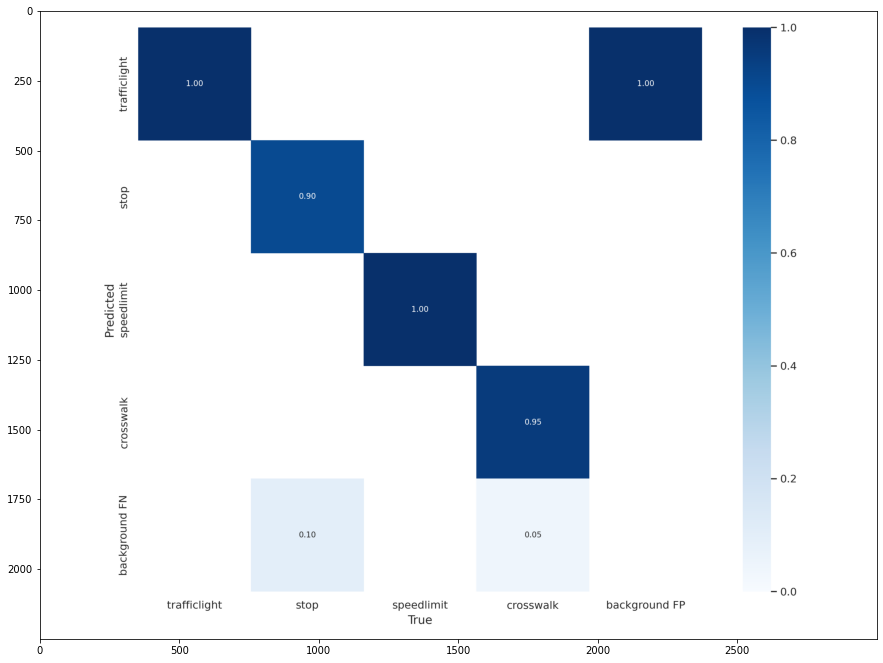

In [92]:
plt.figure(figsize=(15,15)) 
plt.imshow(np.array(Image.open("/content/yolov5/runs/train/yolo_road_det/confusion_matrix.png")))

In [87]:
import pandas as pd

results = pd.read_csv("/content/yolov5/runs/train/yolo_road_det/results.csv")

In [88]:
results

epoch        train/box_loss        train/obj_loss  \
0                      0              0.093003              0.024395   
1                      1              0.067495              0.020529   
2                      2              0.062100              0.015979   
3                      3              0.056390              0.012210   
4                      4              0.050365              0.010151   
5                      5              0.044207              0.009663   
6                      6              0.038362              0.008168   
7                      7              0.037254              0.007844   
8                      8              0.034582              0.007563   
9                      9              0.032427              0.007331   
10                    10              0.030122              0.007209   
11                    11              0.032686              0.007467   
12                    12              0.031081              0.007203   
13                    13              0.028013              0.007048   
14                    14              0.027399              0.006748   
15                    15              0.026673              0.006976   
16                    16              0.025905              0.006797   
17                    17              0.027037              0.006622   
18                    18              0.025303              0.006284   
19                    19              0.023223              0.006278   
20                    20              0.022389              0.005844   
21                    21              0.022996              0.006246   
22                    22              0.022359              0.006256   
23                    23              0.022124              0.005972   
24                    24              0.021337              0.005717   
25                    25              0.021663              0.005651   
26                    26              0.021543              0.005790   
27                    27              0.019773              0.005567   
28                    28              0.020586              0.005664   
29                    29              0.019601              0.005878   
30                    30              0.019318              0.005440   
31                    31              0.018725              0.005241   
32                    32              0.017892              0.005162   
33                    33              0.018192              0.005230   
34                    34              0.017295              0.005049   
35                    35              0.016504              0.004859   
36                    36              0.016904              0.005294   
37                    37              0.016747              0.005139   
38                    38              0.016264              0.005150   
39                    39              0.015522              0.005002   
40                    40              0.015154              0.004715   
41                    41              0.015401              0.004891   
42                    42              0.014573              0.005071   
43                    43              0.014451              0.004829   
44                    44              0.013713              0.004570   
45                    45              0.014320              0.004526   
46                    46              0.014142              0.004343   
47                    47              0.013438              0.004668   
48                    48              0.013253              0.004317   
49                    49              0.013388              0.004452   

          train/cls_loss     metrics/precision        metrics/recall  \
0               0.022682               0.88280              0.126540   
1               0.016101               0.89780              0.098765   
2               0.012868               0.46906              0.717230   
3               0.009793               0.51832            

In [ ]:
!python detect.py --source /content/Road_Sign_Dataset/images/test/ --weihts /content/yolov5/runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name road_sign --line-thickness 1

In [78]:
# !rm -rf /content/yolov5/runs/train/yolo_road_det

In [72]:
# !rm -rf /content/yolov5/runs/detect/road_sign

<a name='te'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Test du modele
        </h1>
    </div>
</div>

In [56]:
def show_images_from_directory(path, num_sample):
    fig = plt.figure(figsize=(30,50))
    fig.patch.set_facecolor('#377AB7')
    images = os.listdir(path + "/" )[:num_sample]
    for i in range(num_sample):
        img = imgmp.imread(path+"/"+images[i])
        plt.subplot(num_sample/num_sample+1, num_sample, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show() 

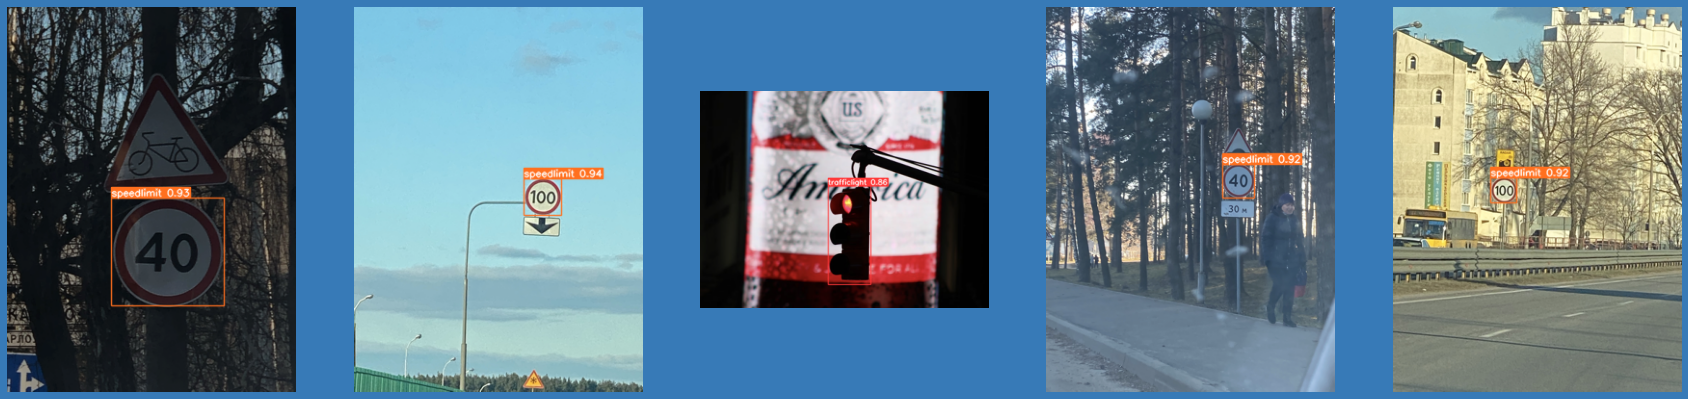

In [93]:
import matplotlib.image as imgmp
sign_list =["trafficlight","stop", "speedlimit","crosswalk"]
show_images_from_directory("/content/yolov5/runs/detect/road_sign", 5)

In [63]:
import os
from PIL import Image, ImageDraw
import random
import numpy as np
import matplotlib.pyplot as plt
detections_dir = "/content/yolov5/runs/detect/road_sign"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]


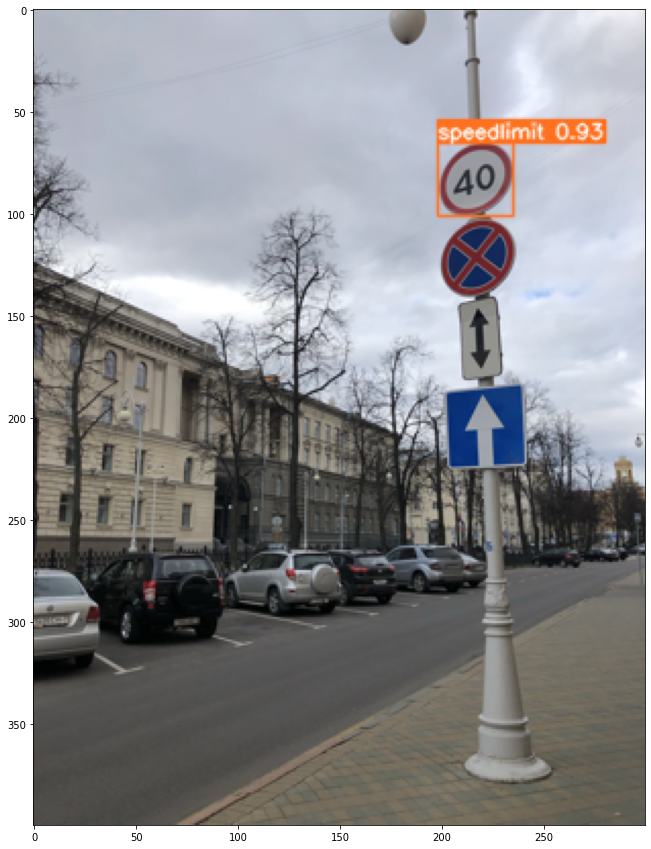

In [75]:
plt.figure(figsize=(15,15))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

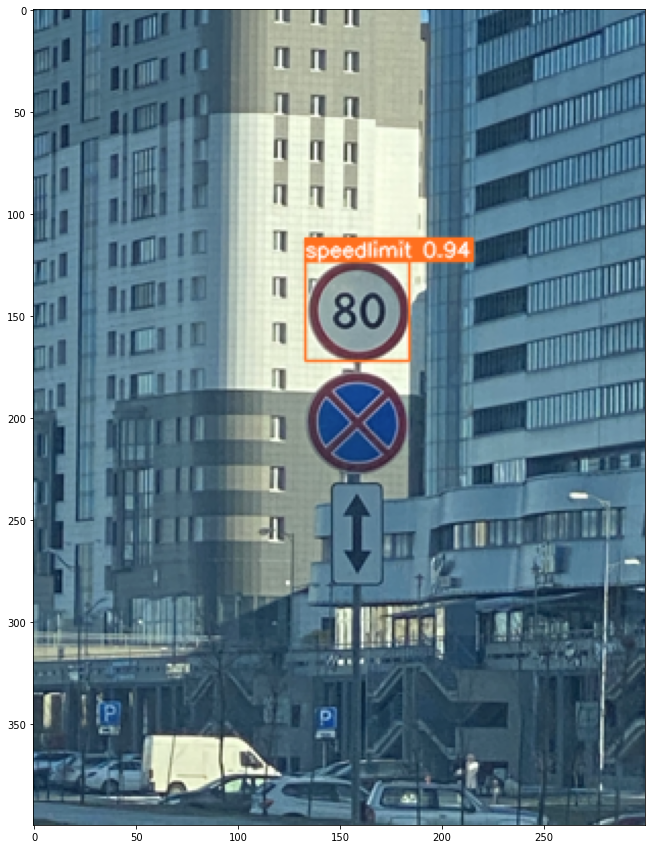

In [76]:
plt.figure(figsize=(15,15))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

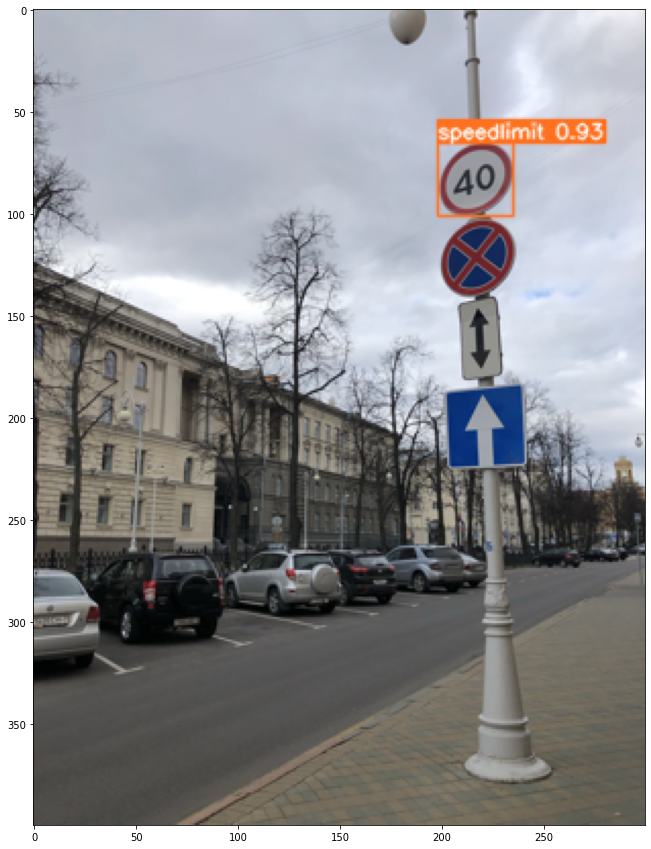

In [77]:
plt.figure(figsize=(15,15))
random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!cp -avr /content/yolov5/runs/ /content/ShardDrives/MyDrive/roadsign/results

In [ ]:
import pandas as pd

results = pd.read_csv("/content/ShardDrives/MyDrive/roadsign/results/train/yolo_road_det/results.csv",skipinitialspace=True)

results.columns

In [ ]:
# 'epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss',
#        'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5',
#        'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss',
#        'x/lr0', 'x/lr1', 'x/lr2'

fig = plt.figure(figsize=(25,10))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(results['train/box_loss'])
plt.plot(results['train/obj_loss'])
plt.plot(results[ 'train/cls_loss'])
plt.plot(results[ 'metrics/precision'])
plt.plot(results['metrics/recall'])
plt.plot(results[ 'metrics/mAP_0.5'])
plt.plot(results['metrics/mAP_0.5:0.95'])
plt.plot(results['val/box_loss'])
plt.plot(results['val/obj_loss'])
plt.plot(results['val/cls_loss'])
plt.plot(results['x/lr0'])
plt.plot(results['x/lr1'])
plt.plot(results[ 'x/lr2'])

# plt.title(modele_name+' '+ first_score, fontsize=18)
# plt.ylabel(first_score)
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# # summarize history for loss
# plt.subplot(1, 2, 2)
# plt.plot(dict_history[second_score])
# plt.plot(dict_history['val_' + second_score],
#           linestyle='--', color="red")
# plt.title(modele_name +' '+ second_score, fontsize=18)
# plt.ylabel(second_score)
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()